# 2024亚太杯C题第三问第二小问

## 一、数据导入和平稳性检验
采用图检验，发现数据均值不为常数，显然不平稳

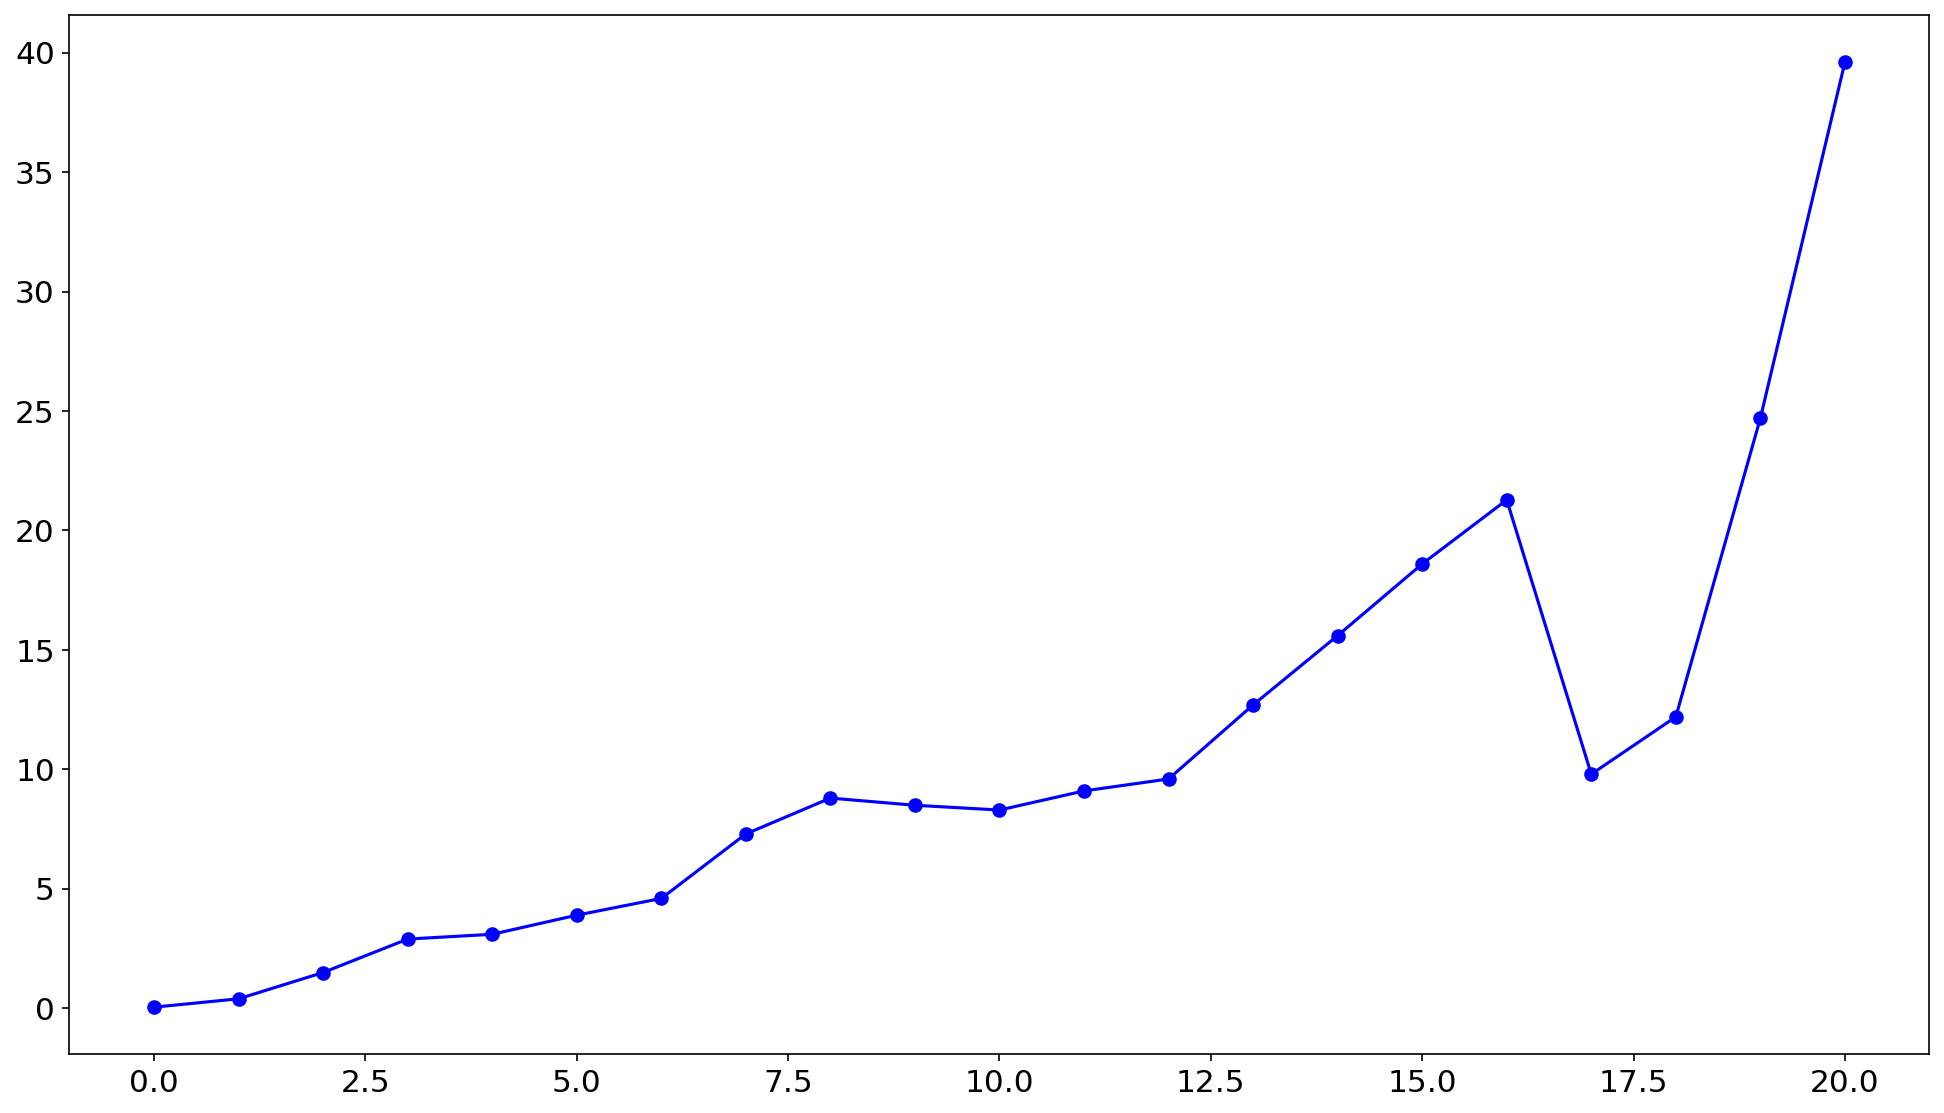

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from arch.unitroot import PhillipsPerron
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
import pandas as pd
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import acorr_lm
from arch.univariate import arch_model

## 数据导入
data = [0.05, 0.4, 1.5, 2.9, 3.1, 3.9, 4.6, 7.3, 8.8, 8.5, 8.3, 9.1, 9.6, 12.7, 15.6, 18.6, 21.28, 9.8, 12.2, 24.7, 39.6]

# 绘制序列图做平稳性检验
plt.figure(figsize=(16, 9), dpi=150)
plt.plot(data, linestyle='-', color='b', marker='o', markerfacecolor='b')
plt.xlabel('', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(fname='中国宠物食品出口总额.png')

## 二、差分与平稳性检验
### 2.1 一阶差分
为了解决不平稳的问题，先采用一阶差分

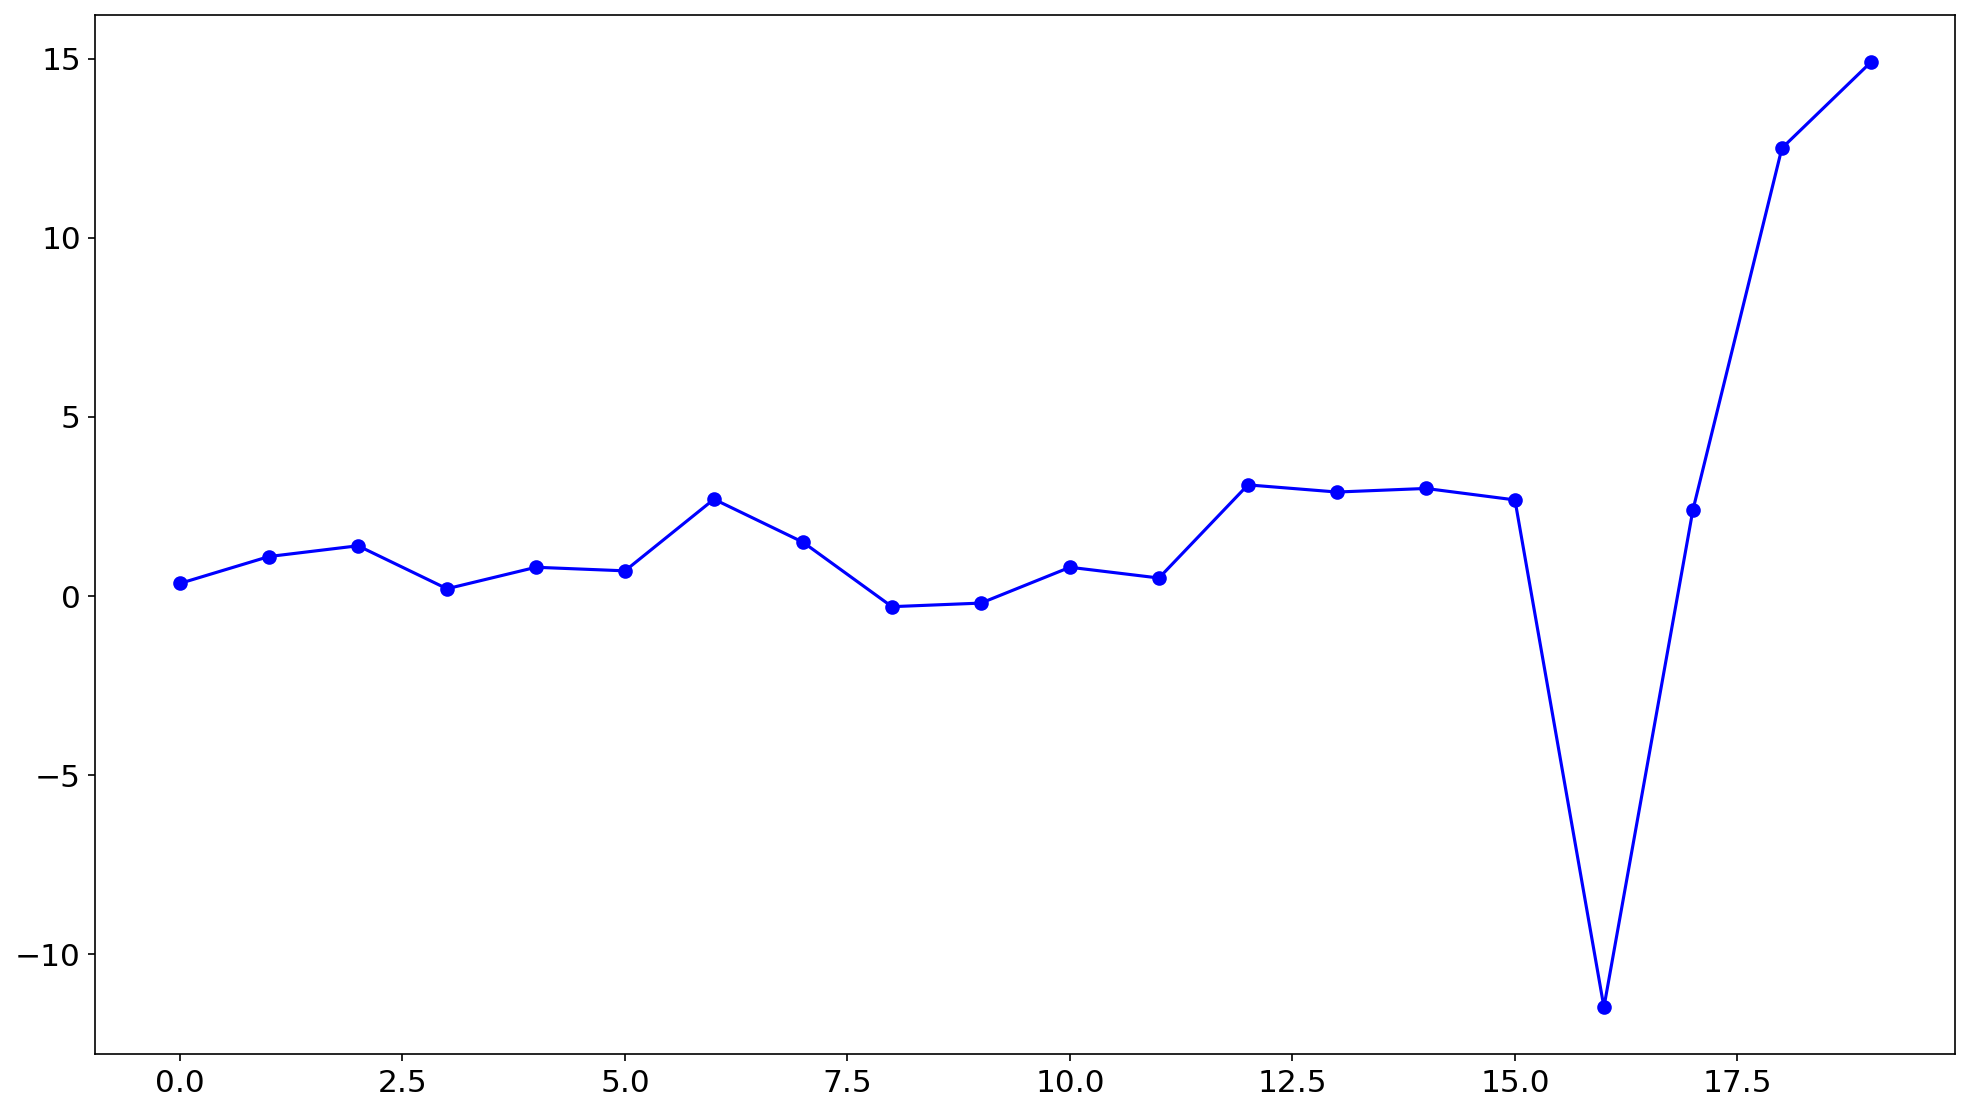

In [2]:
## 数据差分与平稳性检验
# 一阶差分
first_order_diff = np.diff(data)

# 绘制一阶差分后的序列图
plt.figure(figsize=(16, 9), dpi=150)
plt.plot(first_order_diff, linestyle='-', color='b', marker='o', markerfacecolor='b')
plt.xlabel('', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(fname='一阶差分后的的序列图.png')

### 2.2 PP检验
原假设$$H0:时间序列包含单位根$$
备择假设$$H1:时间序列为弱平稳$$

In [3]:
# 对一阶差分后的数据做 PP 检验
pp = PhillipsPerron(first_order_diff)
print(pp.summary().as_text())

p_value = pp.pvalue

if p_value < 0.05:
    print("拒绝原假设，PP检验下一阶差分后的数据是平稳数据。")
else:
    print("不拒绝原假设，PP检验下一阶差分后的数据是非平稳数据。")

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.312
P-value                         0.623
Lags                                9
-------------------------------------

Trend: Constant
Critical Values: -3.83 (1%), -3.03 (5%), -2.66 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
不拒绝原假设，PP检验下一阶差分后的数据是非平稳数据。


### 2.3 二阶差分
通过上述分析：即使通过一阶差分也无法实现数据平稳，进一步使用二阶差分

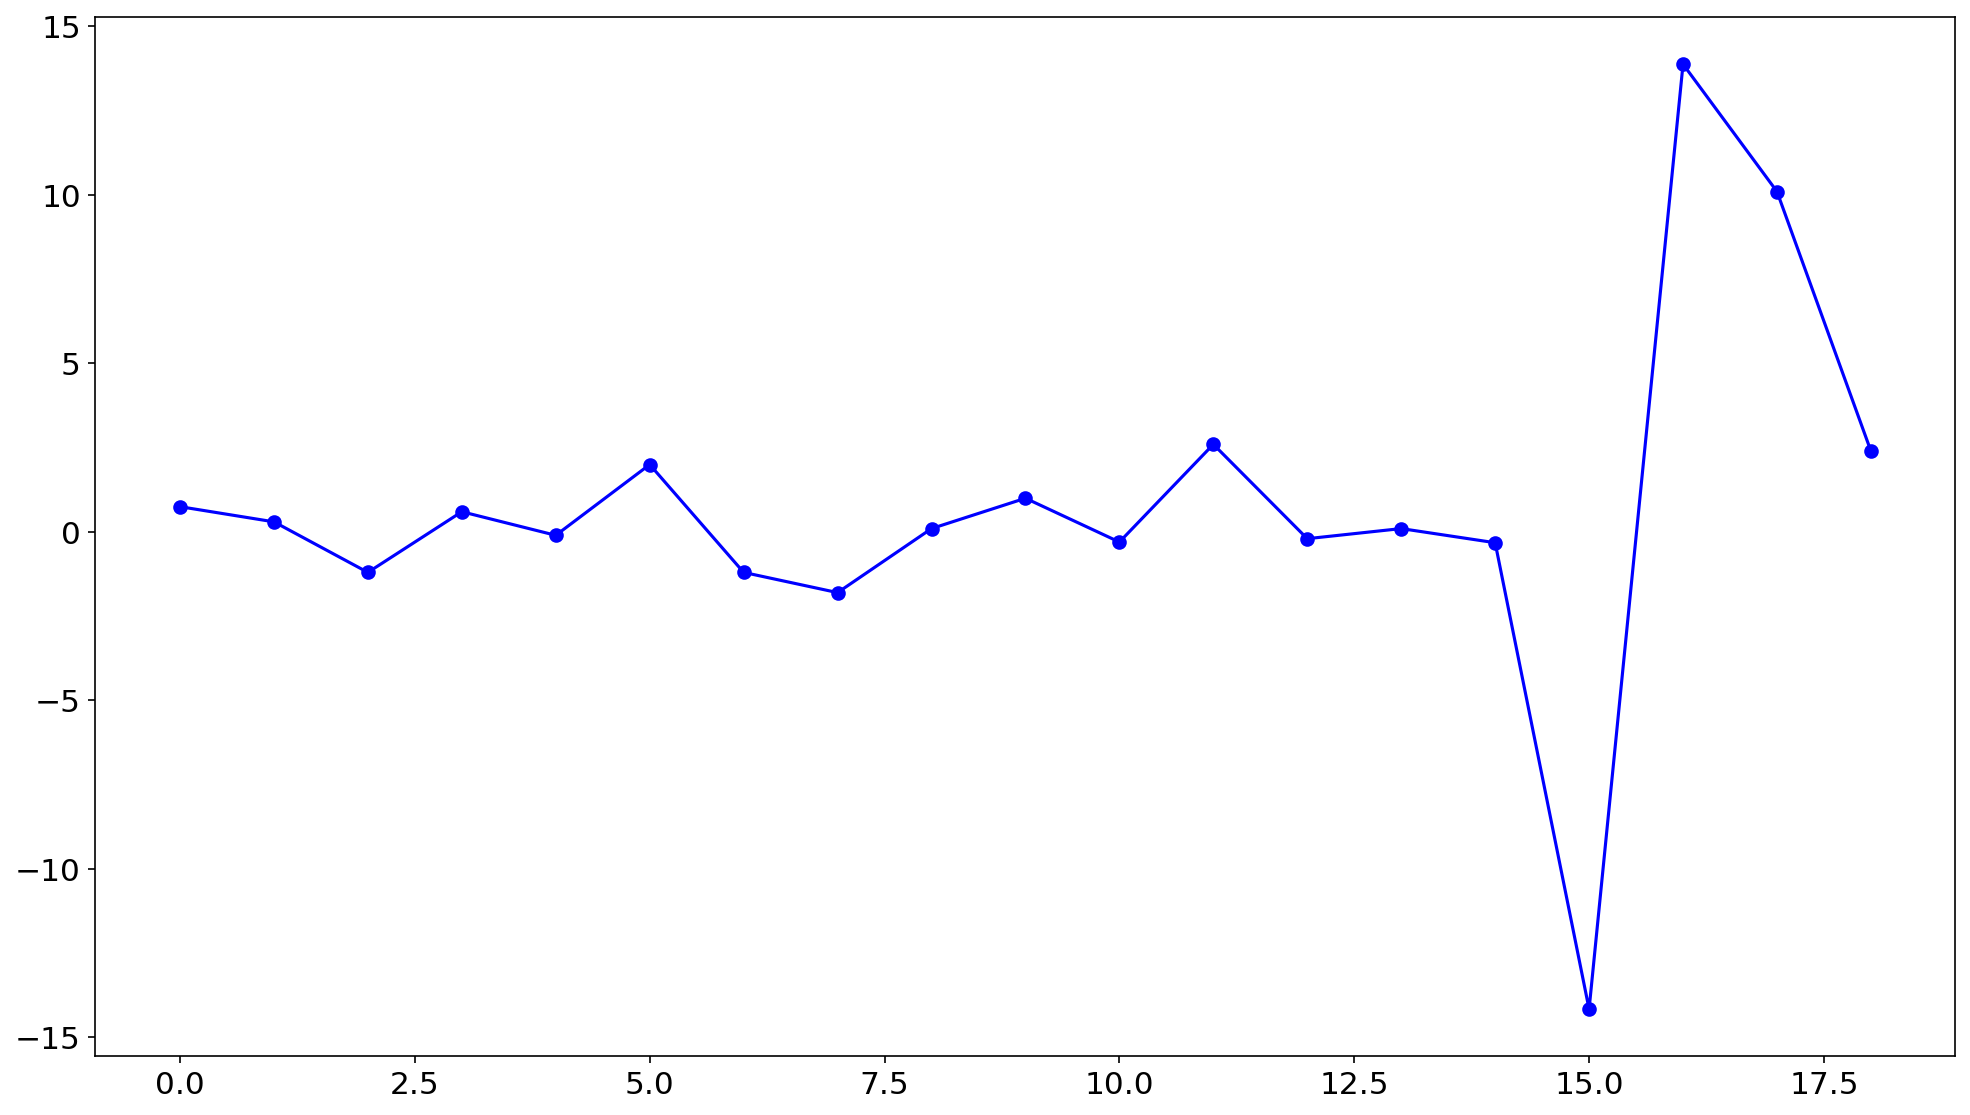

In [4]:
# 二阶差分
second_order_diff = np.diff(first_order_diff)

# 绘制二阶差分后的序列图
plt.figure(figsize=(16, 9), dpi=150)
plt.plot(second_order_diff, linestyle='-', color='b', marker='o', markerfacecolor='b')
plt.xlabel('', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(fname='二阶差分后的的序列图.png')

### 2.4 PP检验
原假设$$H0:时间序列包含单位根$$
备择假设$$H1:时间序列为弱平稳$$

In [5]:
# 对二阶差分后的数据做 PP 检验
pp = PhillipsPerron(second_order_diff)
print(pp.summary().as_text())

p_value = pp.pvalue

if p_value < 0.05:
    print("拒绝原假设，PP检验下二阶差分后的数据是平稳数据。")
else:
    print("不拒绝原假设，PP检验下二阶差分后的数据是非平稳数据。")

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -4.681
P-value                         0.000
Lags                                8
-------------------------------------

Trend: Constant
Critical Values: -3.86 (1%), -3.04 (5%), -2.66 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
拒绝原假设，PP检验下二阶差分后的数据是平稳数据。


## 三、纯随机检验
已经判断差分后的序列为平稳性数据，进一步判断是否为白噪声数据，采用LB检验。  
原假设：$$H_0: \rho_1=\rho_2=\cdots=\rho_m=0, \forall m \geq 1$$  
备择假设：$$H_1: \rho_k \neq 0,  \forall m \geq 1, k \leq m$$  
LB统计量：$$LB=n(n+2) \sum_{k=1}^m\left(\frac{\hat{\rho}_k^2}{n-k}\right) \sim \chi^2(m)$$
从结果上来看，p值小于0.05，拒绝原假设，认为这一组序列为非白噪声序列，不具有纯随机性。

In [6]:
## 纯随机检验
LB = acorr_ljungbox(data, lags=range(1, 10), boxpierce=True, return_df=True)
print(LB)

     lb_stat  lb_pvalue    bp_stat  bp_pvalue
1   7.897558   0.004950   6.867442   0.008778
2   9.893765   0.007106   8.516482   0.014147
3  11.740788   0.008326   9.961979   0.018892
4  15.751470   0.003371  12.926395   0.011641
5  17.940049   0.003022  14.448885   0.012996
6  18.742115   0.004622  14.971972   0.020476
7  18.827620   0.008745  15.024018   0.035693
8  18.872342   0.015557  15.049296   0.058194
9  19.135889   0.024062  15.186799   0.085931


## 四、模型识别
### 4.1 相关图识别

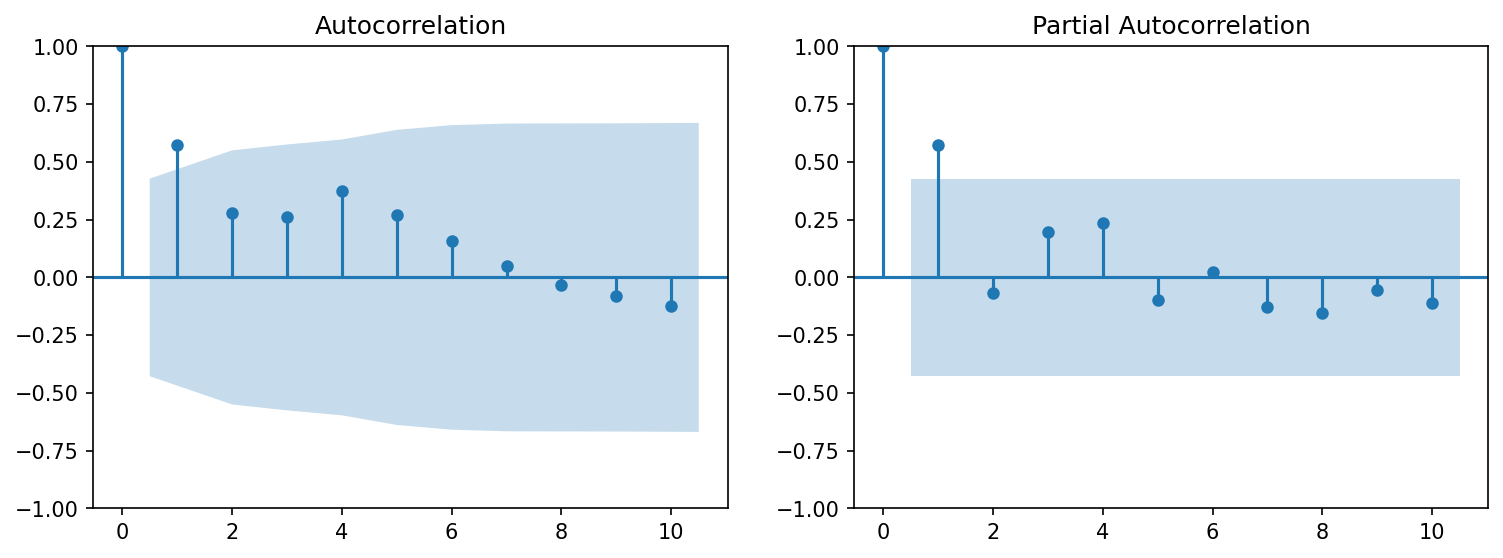

In [8]:
## 模型识别
# 绘制自相关图和偏自相关图并识别模型
fig = plt.figure(figsize=(12, 4), dpi=150)
ax1 = fig.add_subplot(121)
sm.graphics.tsa.plot_acf(data, lags=10, ax=ax1)
ax2 = fig.add_subplot(122)
sm.graphics.tsa.plot_pacf(data, lags=10, ax=ax2)
plt.savefig(fname='相关图.png')

### 4.2 自动识别
相关图难以判断，使用auto_arima比较AIC自动识别模型

In [9]:
# 识别模型
series = pd.Series(data)
model = auto_arima(series, seasonal= False, trace=True)
print(f"自动识别的阶数：(p, d, q) = {model.order}")

'''模型识别为ARIMA(0,1,1)'''

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=124.601, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=123.960, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=122.565, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=125.581, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=124.500, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=124.345, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=126.095, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=122.660, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.354 seconds
自动识别的阶数：(p, d, q) = (0, 1, 1)


'模型识别为ARIMA(0,1,1)'

## 五、模型拟合与参数检验

In [10]:
## 拟合模型
mod = sm.tsa.statespace.SARIMAX(data, order=(0,1,1))
res = mod.fit() 
print(res.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.84569D+00    |proj g|=  4.59740D-02

At iterate    5    f=  2.82523D+00    |proj g|=  1.64600D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6      8      1     0     0   6.525D-06   2.825D+00
  F =   2.8252319444990524     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

 This problem is unconstrained.


## 六、模型的整体效果检验
### 6.1 残差的纯随机性检验

In [11]:
## 均值模型的整体效果检验
# 计算残差序列
residuals = res.resid

# 输出残差序列
print("残差序列：", residuals)

# 检验残差序列为白噪声
LB = acorr_ljungbox(residuals, lags=range(1, 10), boxpierce=True, return_df=True)
print(LB)

残差序列： [ 5.00000000e-02  3.49999432e-01  9.56309467e-01  9.27807318e-01
 -2.77750762e-01  9.44596100e-01  2.06790116e-01  2.59193995e+00
  1.45260479e-01 -3.75928430e-01 -3.49697355e-03  8.01827925e-01
  8.08709829e-02  3.05772736e+00  1.30167352e+00  2.31959293e+00
  1.46750899e+00 -1.22470921e+01  8.80176512e+00  7.89916639e+00
  1.07709702e+01]
    lb_stat  lb_pvalue   bp_stat  bp_pvalue
1  0.024295   0.876136  0.021126   0.884435
2  0.110962   0.946030  0.092721   0.954698
3  2.494610   0.476266  1.958185   0.581131
4  2.520452   0.640977  1.977285   0.739937
5  2.830238   0.726138  2.192788   0.821877
6  2.875124   0.824349  2.222062   0.898185
7  2.975118   0.887294  2.282928   0.942538
8  2.980574   0.935571  2.286012   0.970964
9  3.005025   0.964095  2.298768   0.985815


### 6.2残差的正态性检验
#### 判断标准化残差是否服从标准正态分布  
检验：$$E(\epsilon_t)=0$$
$$D(\epsilon_t)=1$$
$$\epsilon_t服从N(0,1)$$
#### 残差的自相关函数  
计算判断各个残差之间是否相关
#### LB检验  
原假设H0：这组数据为纯随机的，序列值之间相互独立。
$$
H_0: \rho_1=\rho_2=\cdots=\rho_m=0, \forall m \geq 1
$$  
备择假设H1：这组数据非白噪声序列，至少存在一个自相关系数不为零。
$$
H_1: \rho_k \neq 0,  \forall m \geq 1, k \leq m
$$  
采用LB统计量作为检验统计量：
$$
LB=n(n+2) \sum_{k=1}^m\left(\frac{\hat{\rho}_k^2}{n-k}\right) \sim \chi^2(m)
$$

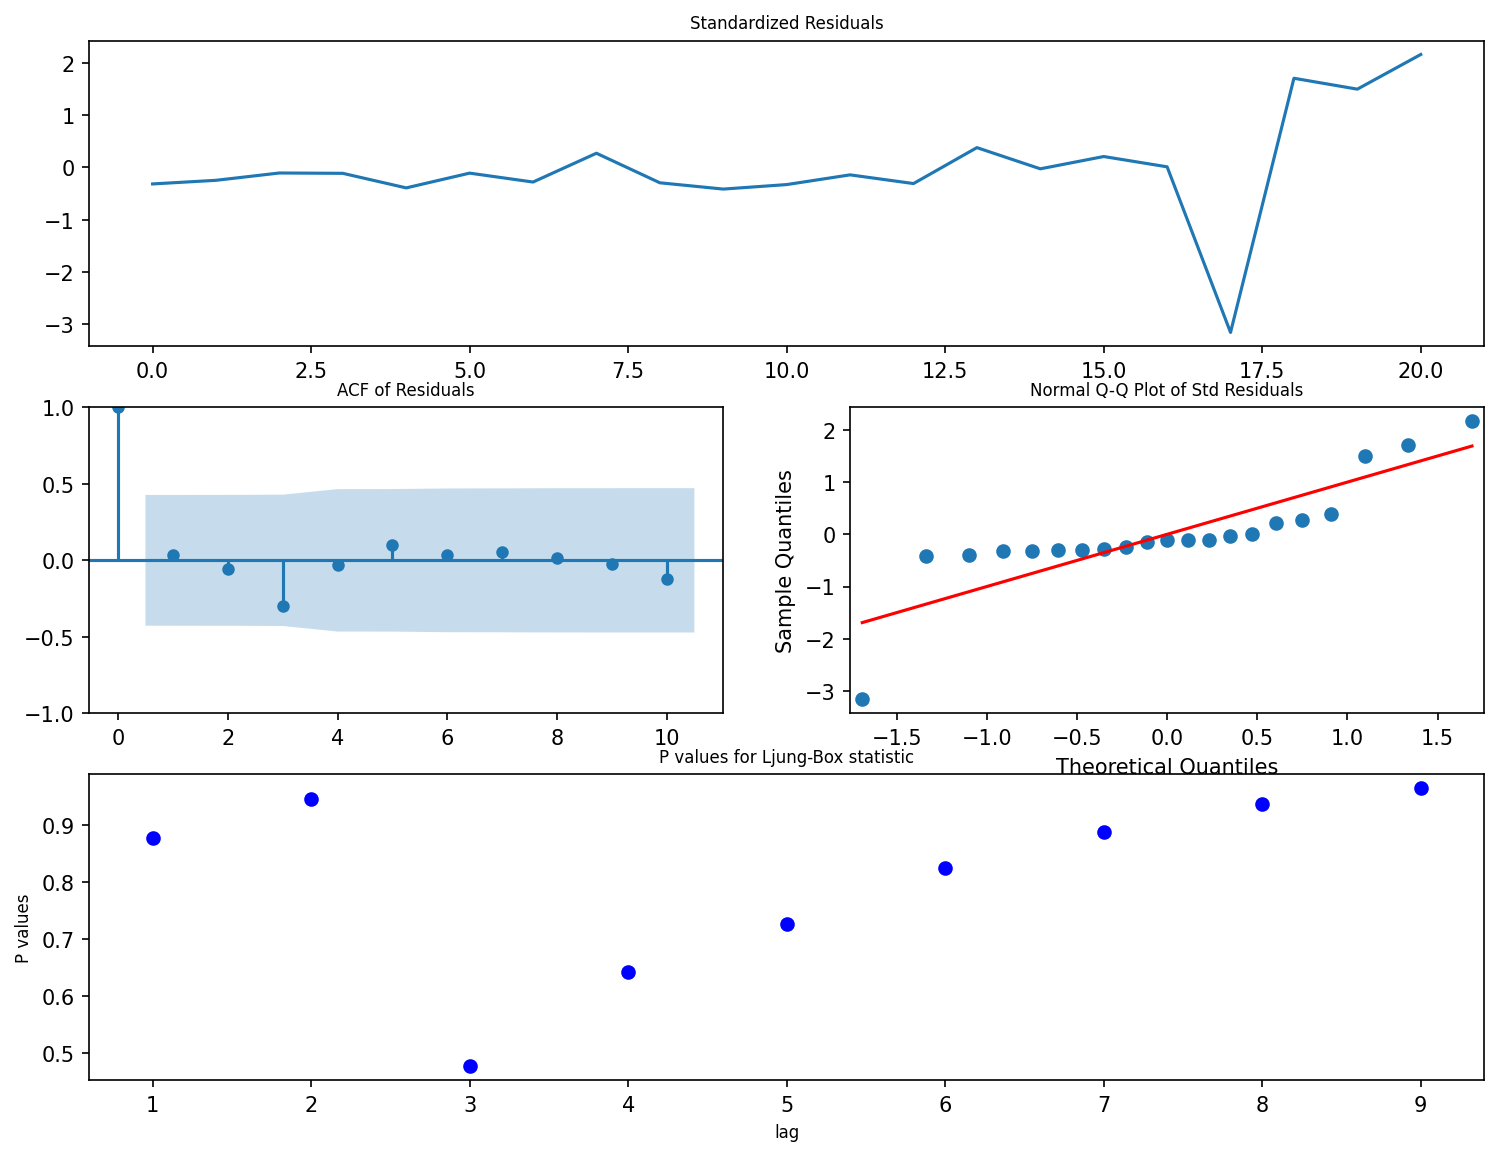

In [12]:
resid_sd = (residuals-np.mean(residuals))/np.std(residuals)
fig = plt.figure(figsize=(12,9),dpi=150)  
ax1 = fig.add_subplot(311)  
ax1.plot(resid_sd);plt.title('Standardized Residuals', fontsize=8)  

ax2 = fig.add_subplot(323)  
plot_acf(residuals, ax=ax2)
plt.title('ACF of Residuals', fontsize=8)  

ax3 = fig.add_subplot(324)  
sm.qqplot(resid_sd, fit=True, line="s",ax=ax3)  
plt.title('Normal Q-Q Plot of Std Residuals', fontsize=8)  

lags = np.arange(1,10)
LB_p = LB.lb_pvalue
ax4 = fig.add_subplot(313)  
ax4.scatter(lags,LB_p,color="blue")
plt.xlabel(xlabel="lag", fontsize=8)  
plt.ylabel(ylabel="P values", fontsize=8)  
plt.title('P values for Ljung-Box statistic', fontsize=8)   
plt.savefig(fname='整体效果检验.png')

### 6.3 残差的自相关性检验
#### 6.3.1 DW检验
原假设$$ H0：P = 0（残差项不存在一阶序列相关）$$
备择假设$$  H1：P ≠ 0（残差项存在一阶序列相关）$$
检验统计量：$$DW=\sum_{t = 2}^{n}\frac{(e_{t}-e_{t - 1})^{2}}{\sum_{t = 2}^{n}e_{t}^{2}}$$
判断$$DW < d_l：拒绝H0，存在正相关性$$
$$d_l < DW < d_u：无法做出确切判断$$
$$d_u < DW < 4 - d_u：接受H0，不存在自相关性$$
$$4 - d_u < DW < 4 - d_l：无法做出确切判断$$
$$DW > 4 - d_l：拒绝H0，存在负相关性$$
其中$d_l$为DW检验统计量的下临界值，$d_u$为DW检验统计量的上临界值。

In [13]:
## 残差的自相关检验
# DW检验
dw_stat = durbin_watson(residuals)
print("DW统计量:", dw_stat)
if dw_stat < 1:
    print("DW检验下可能存在正自相关")
elif dw_stat > 3:
    print("DW检验下可能存在负自相关")
else:
    print("DW检验下不存在一阶自相关")

DW统计量: 1.543177966160225
DW检验下不存在一阶自相关


#### 6.3.2 Durbin h检验
检验统计量$$Dh=DW\frac{n}{1-n\sigma^2_\beta}$$

In [14]:
# Durbin-h检验
# 首先获取滞后因变量系数估计量的方差
n = len(residuals)
var_beta_1 = np.var(residuals)  # 不知道这个方差写错了没
h = dw_stat * (n / (1 - n * var_beta_1))
print("Dh统计量:", h)
z_alpha_2 = 1.96
if np.abs(h) > z_alpha_2:
    print("Dh检验下拒绝原假设，残差存在自相关性")
else:
    print("Dh检验下不拒绝原假设，残差不存在自相关性")

Dh统计量: -0.08273515337724288
Dh检验下不拒绝原假设，残差不存在自相关性


### 6.4 残差的异方差性检验
#### 6.4.1 White 检验
原假设$$H0：残差项的方差是常数，不存在异方差$$ 
备择假设$$H1：残差项的方差是不常数，存在异方差$$
采用LM统计量作为检验统计量：
$$
LM=nR^2\sim \chi^2_\alpha(q)
$$

In [15]:
## 异方差检验
# White 检验
data_for_white_test = data[:len(residuals)]
exog = np.column_stack((np.ones(len(residuals)), data_for_white_test))

white_test_results = het_white(residuals, exog)
print(f"White 检验统计量：{white_test_results[0]}")
print(f"White 检验的p 值：{white_test_results[1]}")

if white_test_results[1] < 0.05:
    print('White检验下存在异方差性。')
else:
    print('White检验下不存在异方差性。')

White 检验统计量：6.308797689635803
White 检验的p 值：0.04266404099440393
White检验下存在异方差性。


#### 6.4.2 Portmanteau Q检验
原假设
$$H0:\rho_1 = \rho_2 = \cdots = \rho_q = 0$$
备择假设
$$H1:\rho_1,\rho_2,\cdots,\rho_q不全为0$$
检验统计量
$$ Q(q) = n(n+2)\sum_{i=1}^{q}\frac{\rho^2_i}{n-i} \sim \chi^2(q-1)$$

In [16]:
# Portmanteau Q检验
Q = acorr_ljungbox(residuals**2, lags=range(1, 10), boxpierce = True, return_df = True )
print(Q)
# p值小于0.05拒绝原假设，存在异方差性

     lb_stat  lb_pvalue    bp_stat  bp_pvalue
1   5.106212   0.023840   4.440185   0.035102
2   8.349362   0.015380   7.119308   0.028449
3  11.790831   0.008135   9.812632   0.020228
4  11.791254   0.018973   9.812944   0.043699
5  11.822792   0.037298   9.834884   0.080051
6  11.918366   0.063815   9.897215   0.129048
7  12.040708   0.099228   9.971684   0.190184
8  12.343279   0.136532  10.142702   0.255153
9  12.760733   0.173735  10.360504   0.322096


#### 6.4.3 拉格朗日乘子(LM)检验
$$H0:\rho_1 = \rho_2 = \cdots = \rho_q = 0$$
备择假设
$$H1:\rho_1,\rho_2,\cdots,\rho_q不全为0$$
检验统计量
$$LM(q)=W^TW，W=(\frac{\rho^2_1}{\hat{\sigma}^2},\frac{\rho^2_2}{\hat{\sigma}^2},\cdots,\frac{\rho^2_q}{\hat{\sigma}^2})$$

In [17]:
# LM检验
for n in range(1, 10):
    alm = acorr_lm(residuals, nlags = n)[0:2]
    print(alm)
# （T值，p值）p值小于0.05拒绝原假设，存在异方差性

(0.02917668742388635, 0.8643717126202195)
(0.09462352369451887, 0.9537899959025101)
(9.538208471026223, 0.022928341275114596)
(11.539271574047975, 0.021127315556091555)
(11.171852096098831, 0.04807714065356434)
(10.680933386058264, 0.09875247857390451)
(10.267646910003661, 0.1739067079618964)
(10.099775281171285, 0.25809274391722803)
(11.365313500789547, 0.25149709920026336)


### 6.5 残差异方差性的解决（EGARCH）

In [18]:
## 残差异方差性的解决 GARCH 模型
vt_model = arch_model(residuals, mean='Zero', lags=2, vol="EGARCH").fit(disp="off")  
print(vt_model.summary().tables[1])  

## GARCH模型的检验
# 纯随机检验
h_t = vt_model.conditional_volatility  
e_t = residuals/(np.sqrt(h_t))  
LB = acorr_ljungbox(e_t, lags=range(1, 10), boxpierce=True, return_df=True)  
print(LB)

                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.5701      0.174      3.272  1.068e-03 [  0.229,  0.912]
alpha[1]       0.9476      0.431      2.197  2.805e-02 [  0.102,  1.793]
beta[1]        0.9028      0.146      6.178  6.471e-10 [  0.616,  1.189]
    lb_stat  lb_pvalue   bp_stat  bp_pvalue
1  0.314497   0.574934  0.273475   0.601010
2  0.899485   0.637792  0.756727   0.684982
3  2.935514   0.401675  2.350140   0.502983
4  3.633271   0.457905  2.865874   0.580516
5  3.980058   0.552291  3.107117   0.683476
6  4.088836   0.664656  3.178059   0.786190
7  4.343817   0.739433  3.333265   0.852557
8  4.533543   0.806068  3.440502   0.903758
9  4.534156   0.872882  3.440822   0.944232


## 七、模型的预测

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.84569D+00    |proj g|=  4.59740D-02

At iterate    5    f=  2.82523D+00    |proj g|=  1.64600D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6      8      1     0     0   6.525D-06   2.825D+00
  F =   2.8252319444990524     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
        mean    mean_se   90%lower   90%upper   95%lower   95%upper
0  45.230171   4.662603  37.560872  52.899470  36.091637  54.368

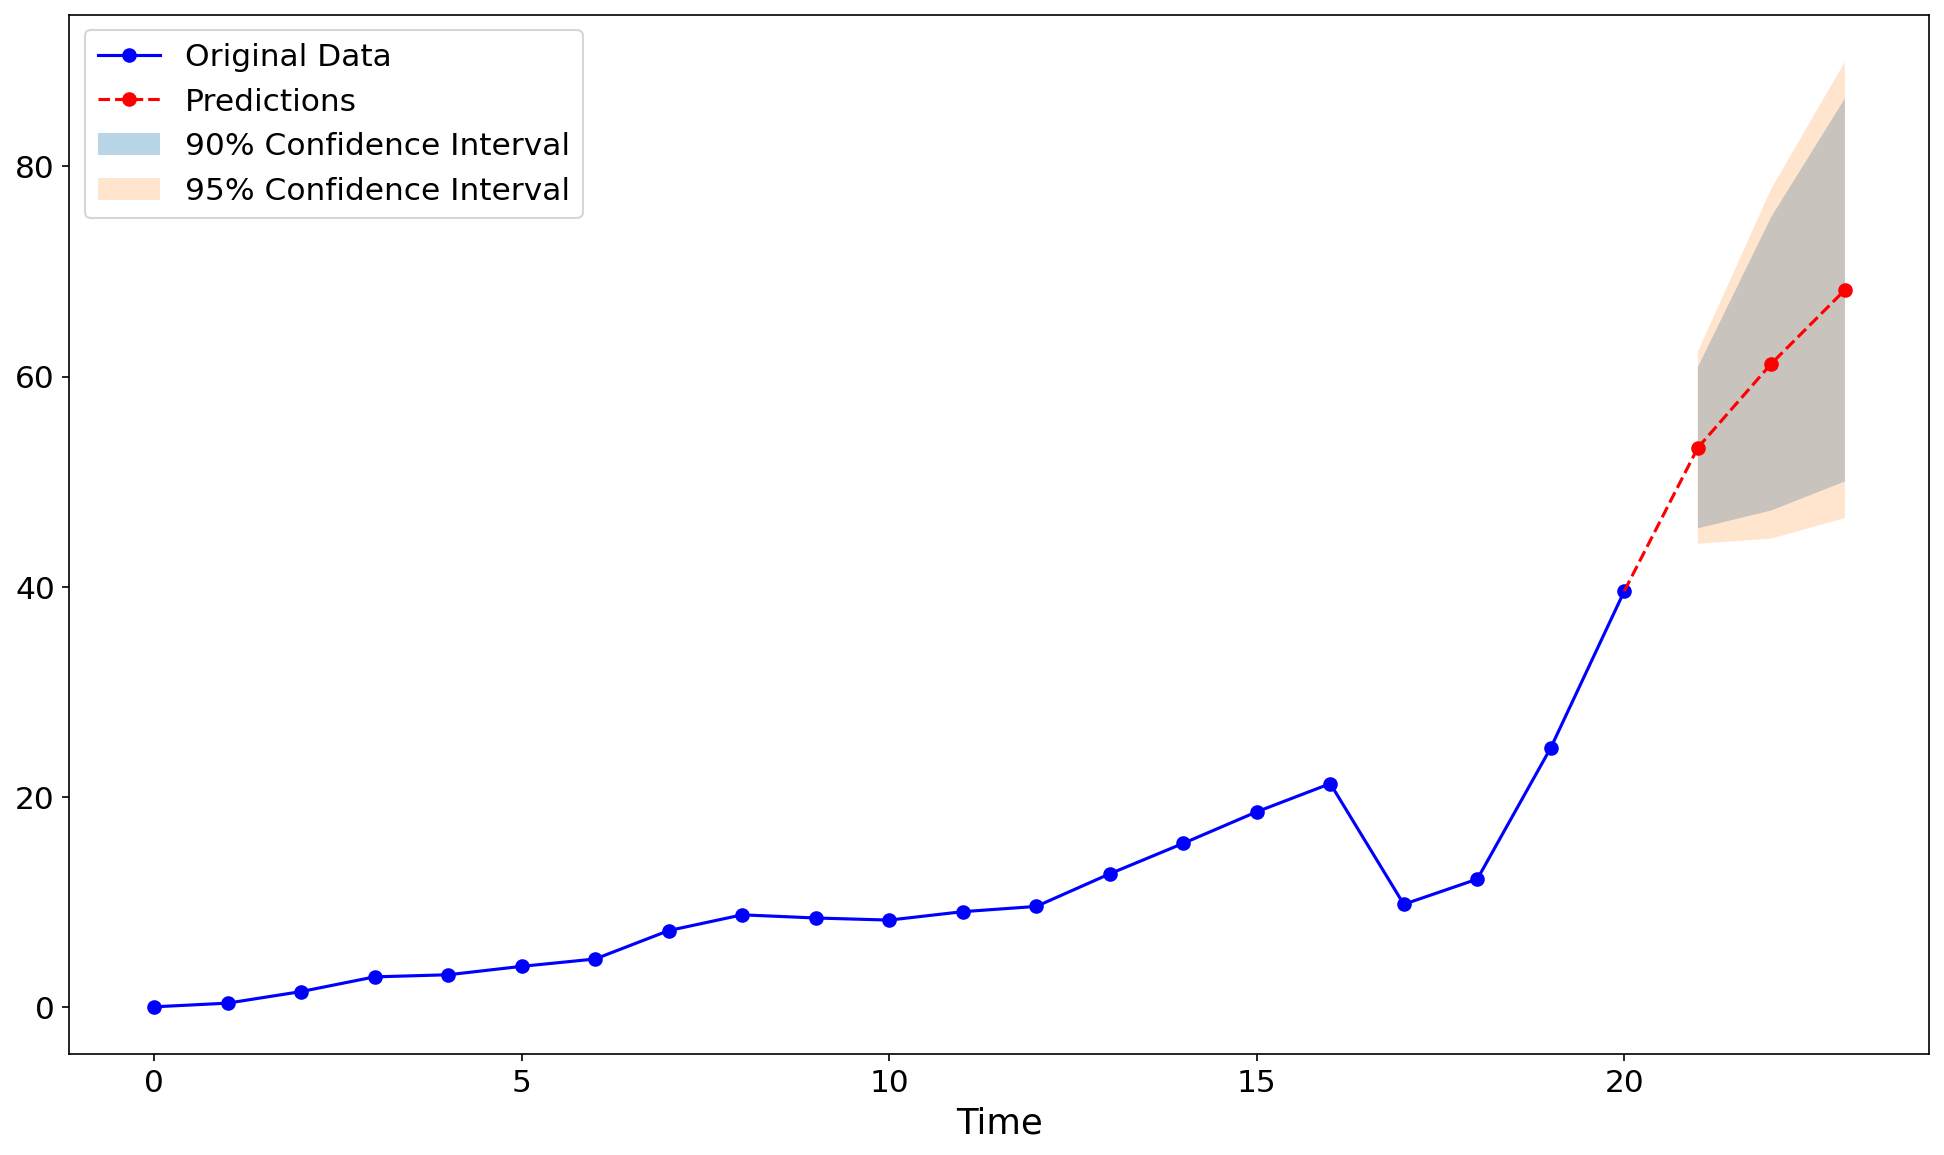

In [19]:
## 模型的预测
mod = sm.tsa.statespace.SARIMAX(data, order=(0,1,1))
res = mod.fit() 
df_fore = res.get_forecast(steps=3)

confint1=df_fore.summary_frame(alpha=0.10)
confint2=df_fore.summary_frame(alpha=0.05).iloc[:,2:]
confint1.columns=["mean","mean_se","90%lower","90%upper"]
confint2.columns=["95%lower","95%upper"]
confint = pd.concat([confint1,confint2],axis=1,ignore_index=False)
print(confint)

A = (8 , 16, 23)
confint["mean"] = (confint["mean"] + A)
confint["90%lower"] = (confint["90%lower"] + A)
confint["90%upper"] = (confint["90%upper"] + A)
confint["95%lower"] = (confint["95%lower"] + A)
confint["95%upper"] = (confint["95%upper"] + A)
print('预测值', confint["mean"])

plt.figure(figsize=(16, 9), dpi=150)
plt.plot(range(len(data)), data, linestyle='-', color='b', marker='o', markerfacecolor='b', label='Original Data')
plt.plot(range(len(data), len(data) + len(confint["mean"])), confint["mean"], linestyle='--', color='r', marker='o', markerfacecolor='r', label='Predictions')
plt.fill_between(range(len(data), len(data) + len(confint["mean"])), confint["90%lower"], confint["90%upper"], alpha=0.3, label='90% Confidence Interval')
plt.fill_between(range(len(data), len(data) + len(confint["mean"])), confint["95%lower"], confint["95%upper"], alpha=0.2, label='95% Confidence Interval')
last_data_index = len(data) - 1
last_pred_index = len(data)
plt.plot([last_data_index, last_pred_index], [data[last_data_index], confint["mean"][last_pred_index-len(data)]], linestyle='--', color='r')
plt.xlabel('Time', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper left',fontsize=15)
plt.savefig(fname='预测结果.png')

备注：模型为  
$$\begin{cases}
ARIMA(0,1,1) \\ 
EGARCH(1,1)
\end{cases}$$
具体而言是：
$$\begin{cases}
x_t = x_{t-1} + \epsilon_t + 0.5227\epsilon_{t-1} \\ 
\epsilon_t = \sqrt{h_t}e_t \\
ln(h_t) = 0.5701 + 0.9028ln(h_{t-1}) + 0.9476(\left| \frac{\epsilon_{t-1}}{\sqrt{h_{t-1}}} \right|-E\left| \frac{\epsilon_{t-1}}{\sqrt{h_{t-1}}} \right|)
\end{cases}$$